# Imports

In [19]:
import re
import numpy as np
import scipy
import pandas as pd
from tqdm import tqdm
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu

# Data Preprocessing 

Отсюда и далее slot == 0 означает контрользную группу, 1 -- эксперементальную

In [2]:
#<выборка, userID, дата, браузер, число кликов на данном запросе>
#slot=exp	userID=1	ts=2016-03-03	browser=Browser #2	all_cl=1

patt = re.compile("[^\t]+")

table = []
with open('log.txt') as f:
    lines = f.readlines()
    for l in tqdm(lines):
        if len(l) > 4:
            l = l.split()
            slot = int(l[0][-1] == 'p')
            userID = int(l[1][7:])
            ts = l[2][3:]
            browser = int(l[4][1:])
            all_cl = int(l[5][7:])
            table.append([slot, userID, ts, browser, all_cl])
df = pd.DataFrame(table)
df.columns = ['slot', 'userID', 'ts', 'browser', 'all_cl']


100%|██████████| 6069254/6069254 [00:33<00:00, 181479.09it/s]


Посмортимна данные и их количество

In [3]:
df.head()

,slot,userID,ts,browser,all_cl
0,1,1,2016-03-03,2,1
1,1,1,2016-03-03,2,5
2,1,1,2016-03-03,2,1
3,1,1,2016-03-03,2,1
4,1,1,2016-03-03,2,6


In [4]:
df.size

30346265

In [5]:
df.tail()

,slot,userID,ts,browser,all_cl
6069248,1,205048,2016-03-02,20,1
6069249,1,205049,2016-03-02,20,1
6069250,1,205049,2016-03-02,20,5
6069251,1,205049,2016-03-02,20,1
6069252,1,603137,2016-03-02,2,3


# Посчитаем метрику "сумма кликов" для эксперимента и контроля

In [6]:
dfgrouped = df.groupby('userID')['all_cl'].sum()
control = dfgrouped.loc[np.unique(df.userID[df.slot == 0])]
exp = dfgrouped.loc[np.unique(df.userID[df.slot == 1])]

Разделим выборку: сравним среднее и количество

In [7]:
np.mean(control), np.mean(exp)

(11.287332273762974, 11.589351572215314)

In [8]:
control.size, exp.size

(284392, 281450)

Посчитаем теста Манна-Уитни

Ограничения применимости критерия:
1. В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти.
2. В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10).


Это не выполнено для данной выборки, онако, как написано тут -- https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php, если дискретное распределение приближает непрерывное распределние его можно использовать.

In [9]:
_, p_value = scipy.stats.mannwhitneyu(control, exp, alternative='less')
p_value

4.3471471887604393e-75

Также посчитаем тест Kolmogorov-Smirnov

In [10]:
_, p_value = scipy.stats.ks_2samp(exp, control)
p_value

2.9236023409457489e-70

Мы видим, что p_value очень маленько. Поэтому можно сказать, что среднее контрольной группы меньше, чем эксперементальной

# Узнаем локализуется ли изменение кликов в каком-либо срезе

Посмотрим срез по браузерам

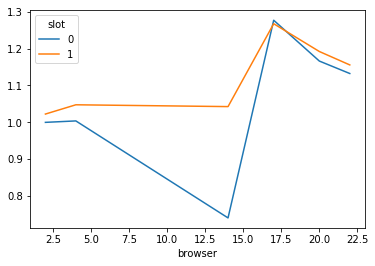

In [11]:
df.pivot_table(values='all_cl', index='browser', columns='slot', aggfunc=np.mean).plot();

Посмотрим срез по дате

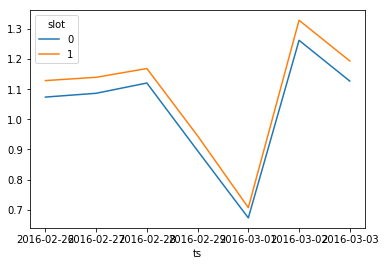

In [12]:
df.pivot_table(values='all_cl', index='ts', columns='slot', aggfunc=np.mean).plot();

Видно, что на 14 браузер происходит локализация кликов

Посмотрим на него отдельно

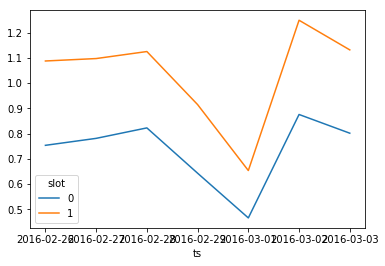

In [13]:
df[df.browser == 14].pivot_table(values='all_cl', index='ts', columns='slot', aggfunc=np.mean).plot();

Проверим значимость различия статистически.

In [20]:
df14 = df[df.browser == 14]
control = dfgrouped.loc[np.unique(df14.userID[df14.slot == 0])]
exp = dfgrouped.loc[np.unique(df14.userID[df.slot == 1])]
_, pvalue = mannwhitneyu(control, exp, alternative='less')
pvalue

0.0

# Какой эффект имело эксперементальное изменение

Итак, мы заметили, что на 14 браузере возможно сказался эксперемент. Однако, давайте посмотрим, можно ли об этом говорить в общем случае.

Еще раз посчитаем p_value на тех же тестах

In [15]:
dfn14 = df[df.browser != 14]
del dfn14['browser']
dfn14.reset_index(drop=True, inplace=True)
dfn14.dtypes

slot       int64
userID     int64
ts        object
all_cl     int64
dtype: object

Рассмотирим сумму кликов

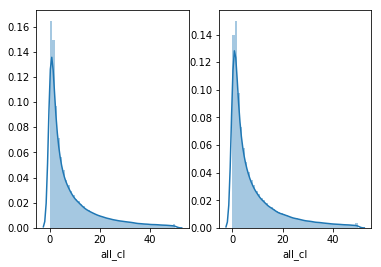

In [27]:
groups = df.groupby('userID')['all_cl']
uclicks = groups.sum()
control = uclicks.loc[np.unique(df.userID[df.slot == 0])]
exp = uclicks.loc[np.unique(df.userID[df.slot == 1])]

In [ ]:
_, pvalue = mannwhitneyu(control, exp)
pvalue

pvalue больше 0.05 значит гипотеза отвергается

Таким образом можно сказать, что если в 14 браузере произошла какая-то аномалия, то только этим вызвано отличие контрольной группы от эксперементальной. Однако, давайте еще рассмотрим pvalue по разным браузера

In [29]:
for browser in np.unique(df.browser):
    dfb = df[df.browser == browser]
    groups = dfb.groupby('userID')['all_cl']
    uclicks = groups.sum()
    control = uclicks.loc[np.unique(dfb.userID[dfb.slot == 0])]
    exp = uclicks.loc[np.unique(dfb.userID[dfb.slot == 1])]
    _, pvalue_less = mannwhitneyu(control, exp, alternative='less')
    _, pvalue_greater = mannwhitneyu(control, exp, alternative='greater')
    print("browser={}, pvalue_less={}, pvalue_greater={}".format(browser, pvalue_less, pvalue_greater))

browser=2, pvalue_less=0.0272438604197241, pvalue_greater=0.9727561514516361
browser=4, pvalue_less=0.40760617658454984, pvalue_greater=0.5923938668034461
browser=14, pvalue_less=0.0, pvalue_greater=1.0
browser=17, pvalue_less=0.03740060143010802, pvalue_greater=0.96259949476143
browser=20, pvalue_less=0.45366656388735377, pvalue_greater=0.5463338763856747
browser=22, pvalue_less=0.7425945262969064, pvalue_greater=0.2574055152210032


## CTR
Ну и чтобы окончательно убедиться, посмотрим на другую кликовую меру

In [30]:
groups = df.groupby('userID')['all_cl']
uclicks = groups.mean()
control = uclicks.loc[np.unique(df.userID[df.slot == 0])]
exp = uclicks.loc[np.unique(df.userID[df.slot == 1])]
    
_, pvalue = mannwhitneyu(control, exp)
pvalue

3.1629583858467e-308

In [ ]:
## Zrate

In [ ]:
groups = df.groupby('userID')['all_cl']
uclicks = groups.agg(lambda _: sum(_ == 0) / len(_))
control = uclicks.loc[np.unique(df.userID[df.slot == 0])]
exp = uclicks.loc[np.unique(df.userID[df.slot == 1])]

# Выводы

In [ ]:
uclicks = df[df.browser != 14].groupby('userID')['all_cl'].sum()
control = uclicks.loc[np.unique(df[df.browser != 14].userID[df[df.browser != 14].slot == 0])]
exp = uclicks.loc[np.unique(df[df.browser != 14].userID[df[df.browser != 14].slot == 1])]

In [ ]:
_, pvalue = scipy.stats.mannwhitneyu(control, exp)
pvalue

In [ ]:
_, p_value = scipy.stats.ks_2samp(exp, control)
p_value

p_value > 0.05

Итог: можно говорить о положительном эффекте только на одном бразере. Про остальные ничего можно сказать, что эффекста не было.